In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
df_trucks = pd.read_csv(
    '/Users/rammaruthi/Desktop/Truck/data/cleaned/df_trucks_cleaned.csv')
df_truck_schedule = pd.read_csv(
    '/Users/rammaruthi/Desktop/Truck/data/cleaned/df_truck_schedule_cleaned.csv')
df_traffic = pd.read_csv(
    '/Users/rammaruthi/Desktop/Truck/data/cleaned/df_traffic_cleaned.csv')
df_routes_weather = pd.read_csv(
    '/Users/rammaruthi/Desktop/Truck/data/cleaned/df_routes_weather_cleaned.csv')
df_routes = pd.read_csv(
    '/Users/rammaruthi/Desktop/Truck/data/cleaned/df_routes_cleaned.csv')
df_drivers = pd.read_csv(
    '/Users/rammaruthi/Desktop/Truck/data/cleaned/df_drivers_cleaned.csv')
df_city_weather = pd.read_csv(
    '/Users/rammaruthi/Desktop/Truck/data/cleaned/df_city_weather_cleaned.csv')

In [9]:
df_trucks.head(10)

,index,truck_id,truck_age,load_capacity_pounds,mileage_mpg,fuel_type,event_date
0,0,42302347,10,3000.0,17,gas,2024-09-19
1,1,27867488,14,10000.0,22,diesel,2024-09-19
2,2,13927774,8,10000.0,19,gas,2024-09-19
3,3,69577118,8,20000.0,19,gas,2024-09-19
4,4,28650047,10,4000.0,21,diesel,2024-09-19
5,5,29303248,9,4000.0,15,gas,2024-09-19
6,6,76304377,8,3000.0,20,diesel,2024-09-19
7,10,45395833,9,6000.0,23,diesel,2024-09-19
8,11,63115903,8,4000.0,16,gas,2024-09-19
9,12,10633538,8,3000.0,21,diesel,2024-09-19


In [10]:
df_trucks.describe()

,index,truck_id,truck_age,load_capacity_pounds,mileage_mpg
count,1201.000000,1.201000e+03,1201.000000,1201.000000,1201.000000
mean,655.477935,3.249928e+07,9.518734,8534.554538,20.837635
std,374.667421,2.187359e+07,1.992032,5576.798364,3.692711
min,0.000000,1.000839e+07,4.000000,3000.000000,11.000000
25%,333.000000,1.814850e+07,8.000000,4000.000000,18.000000
50%,657.000000,2.585326e+07,10.000000,6000.000000,21.000000
75%,980.000000,3.339385e+07,11.000000,15000.000000,24.000000
max,1299.000000,9.998167e+07,15.000000,20000.000000,29.000000


In [11]:
correlation_matrix = df_trucks[['truck_age',
                                'load_capacity_pounds', 'mileage_mpg']].corr()

In [12]:
correlation_matrix

,truck_age,load_capacity_pounds,mileage_mpg
truck_age,1.000000,-0.038934,-0.033176
load_capacity_pounds,-0.038934,1.000000,0.014577
mileage_mpg,-0.033176,0.014577,1.000000


/var/folders/26/hxjlcgbx7h93kg6lmcvht_gh0000gn/T/ipykernel_21350/2303153732.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='fuel_type', data=df_trucks, palette='coolwarm')


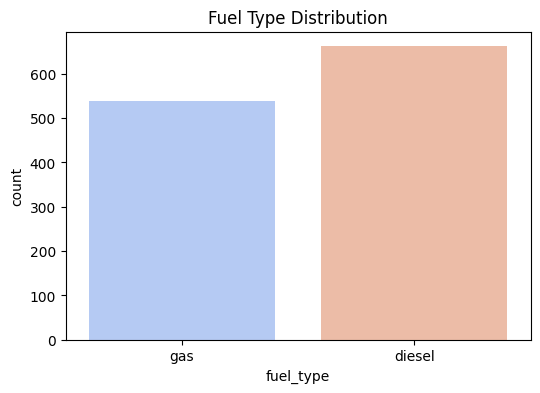

In [13]:
fuel_type_distribution = df_trucks['fuel_type'].value_counts()
plt.figure(figsize=(6, 4))
sns.countplot(x='fuel_type', data=df_trucks, palette='coolwarm')
plt.title('Fuel Type Distribution')
plt.show()

In [14]:
def efficiency_category(mpg):
    if mpg > 20:
        return 'High Efficiency'
    elif 15 <= mpg <= 20:
        return 'Medium Efficiency'
    else:
        return 'Low Efficiency'


df_trucks['efficiency_category'] = df_trucks['mileage_mpg'].apply(
    efficiency_category)

/var/folders/26/hxjlcgbx7h93kg6lmcvht_gh0000gn/T/ipykernel_21350/3100387829.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='efficiency_category', data=df_trucks, palette='coolwarm')


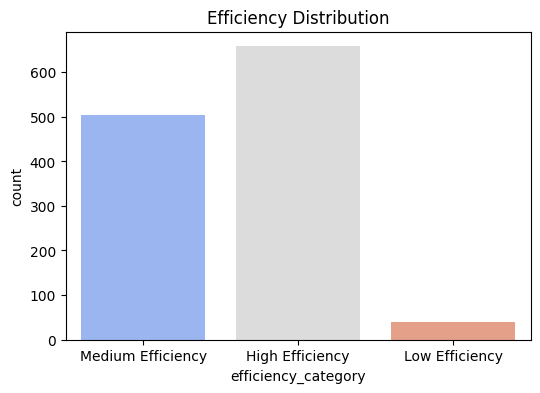

In [15]:
plt.figure(figsize=(6, 4))
sns.countplot(x='efficiency_category', data=df_trucks, palette='coolwarm')
plt.title('Efficiency Distribution')
plt.show()

In [16]:
df_trucks

,index,truck_id,truck_age,load_capacity_pounds,mileage_mpg,fuel_type,event_date,efficiency_category
0,0,42302347,10,3000.0,17,gas,2024-09-19,Medium Efficiency
1,1,27867488,14,10000.0,22,diesel,2024-09-19,High Efficiency
2,2,13927774,8,10000.0,19,gas,2024-09-19,Medium Efficiency
3,3,69577118,8,20000.0,19,gas,2024-09-19,Medium Efficiency
4,4,28650047,10,4000.0,21,diesel,2024-09-19,High Efficiency
...,...,...,...,...,...,...,...,...
1196,1295,17792974,11,4000.0,22,diesel,2024-09-19,High Efficiency
1197,1296,17248432,11,6000.0,22,diesel,2024-09-19,High Efficiency
1198,1297,21865328,10,3000.0,15,gas,2024-09-19,Medium Efficiency
1199,1298,33564827,11,15000.0,24,diesel,2024-09-19,High Efficiency


In [17]:
df_trucks = df_trucks.drop(columns=['mileage_mpg'])

In [18]:
df_trucks.head()

,index,truck_id,truck_age,load_capacity_pounds,fuel_type,event_date,efficiency_category
0,0,42302347,10,3000.0,gas,2024-09-19,Medium Efficiency
1,1,27867488,14,10000.0,diesel,2024-09-19,High Efficiency
2,2,13927774,8,10000.0,gas,2024-09-19,Medium Efficiency
3,3,69577118,8,20000.0,gas,2024-09-19,Medium Efficiency
4,4,28650047,10,4000.0,diesel,2024-09-19,High Efficiency


In [19]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
label_encoder_fuel = LabelEncoder()
label_encoder_efficiency = LabelEncoder()

# Apply label encoding to 'fuel_type' and 'efficiency_category'
df_trucks['fuel_type_encoded'] = label_encoder_fuel.fit_transform(
    df_trucks['fuel_type'])
df_trucks['efficiency_category_encoded'] = label_encoder_efficiency.fit_transform(
    df_trucks['efficiency_category'])

# Drop original categorical columns and keep the encoded columns
df_trucks_encoded = df_trucks.drop(
    ['fuel_type', 'efficiency_category'], axis=1)

# Display the encoded DataFrame
print("\nLabel Encoded Trucks Data:")
df_trucks_encoded


Label Encoded Trucks Data:


,index,truck_id,truck_age,load_capacity_pounds,event_date,fuel_type_encoded,efficiency_category_encoded
0,0,42302347,10,3000.0,2024-09-19,1,2
1,1,27867488,14,10000.0,2024-09-19,0,0
2,2,13927774,8,10000.0,2024-09-19,1,2
3,3,69577118,8,20000.0,2024-09-19,1,2
4,4,28650047,10,4000.0,2024-09-19,0,0
...,...,...,...,...,...,...,...
1196,1295,17792974,11,4000.0,2024-09-19,0,0
1197,1296,17248432,11,6000.0,2024-09-19,0,0
1198,1297,21865328,10,3000.0,2024-09-19,1,2
1199,1298,33564827,11,15000.0,2024-09-19,0,0


In [20]:
scalar_trucks = StandardScaler()
df_trucks_encoded[['truck_age', 'load_capacity_pounds']] = scalar_trucks.fit_transform(
    df_trucks_encoded[['truck_age', 'load_capacity_pounds']])

In [21]:
from datetime import datetime
df_trucks_encoded['event_date'] = datetime.today().strftime('%Y-%m-%d')

In [22]:
df_trucks_encoded

,index,truck_id,truck_age,load_capacity_pounds,event_date,fuel_type_encoded,efficiency_category_encoded
0,0,42302347,0.241696,-0.992838,2024-09-19,1,2
1,1,27867488,2.250533,0.262885,2024-09-19,0,0
2,2,13927774,-0.762722,0.262885,2024-09-19,1,2
3,3,69577118,-0.762722,2.056775,2024-09-19,1,2
4,4,28650047,0.241696,-0.813449,2024-09-19,0,0
...,...,...,...,...,...,...,...
1196,1295,17792974,0.743905,-0.813449,2024-09-19,0,0
1197,1296,17248432,0.743905,-0.454671,2024-09-19,0,0
1198,1297,21865328,0.241696,-0.992838,2024-09-19,1,2
1199,1298,33564827,0.743905,1.159830,2024-09-19,0,0


In [23]:
df_trucks_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1201 entries, 0 to 1200
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   index                        1201 non-null   int64  
 1   truck_id                     1201 non-null   int64  
 2   truck_age                    1201 non-null   float64
 3   load_capacity_pounds         1201 non-null   float64
 4   event_date                   1201 non-null   object 
 5   fuel_type_encoded            1201 non-null   int64  
 6   efficiency_category_encoded  1201 non-null   int64  
dtypes: float64(2), int64(4), object(1)
memory usage: 65.8+ KB


Truck Schedule Analysis


In [17]:
df_truck_schedule

,truck_id,route_id,departure_date,estimated_arrival,delay
0,30312694,R-b236e347,2019-01-01 07:00:00,2019-01-01 13:13:12.000000000,0
1,59856374,R-29ea762e,2019-01-01 07:00:00,2019-01-02 04:01:12.000000000,0
2,12602955,R-a3d67783,2019-01-01 07:00:00,2019-01-01 07:45:36.000000000,0
3,46619422,R-31ec9310,2019-01-01 07:00:00,2019-01-01 20:46:48.000000000,0
4,10140178,R-a07c5dbd,2019-01-01 07:00:00,2019-01-01 21:34:11.999999999,0
...,...,...,...,...,...
12303,31047945,R-1484a7ea,2019-02-06 07:00:00,2019-02-13 22:40:12.000000000,0
12304,14758432,R-927cf900,2019-02-06 07:00:00,2019-02-13 18:52:48.000000000,1
12305,31370619,R-5a83ad98,2019-02-06 07:00:00,2019-02-14 08:01:48.000000000,1
12306,67332883,R-991530bc,2019-02-06 07:00:00,2019-02-13 11:14:24.000000000,1


In [18]:
df_truck_schedule['estimated_arrival'] = pd.to_datetime(
    df_truck_schedule['estimated_arrival']).dt.strftime('%Y-%m-%d %H:%M:%S')

In [19]:
df_truck_schedule

,truck_id,route_id,departure_date,estimated_arrival,delay
0,30312694,R-b236e347,2019-01-01 07:00:00,2019-01-01 13:13:12,0
1,59856374,R-29ea762e,2019-01-01 07:00:00,2019-01-02 04:01:12,0
2,12602955,R-a3d67783,2019-01-01 07:00:00,2019-01-01 07:45:36,0
3,46619422,R-31ec9310,2019-01-01 07:00:00,2019-01-01 20:46:48,0
4,10140178,R-a07c5dbd,2019-01-01 07:00:00,2019-01-01 21:34:11,0
...,...,...,...,...,...
12303,31047945,R-1484a7ea,2019-02-06 07:00:00,2019-02-13 22:40:12,0
12304,14758432,R-927cf900,2019-02-06 07:00:00,2019-02-13 18:52:48,1
12305,31370619,R-5a83ad98,2019-02-06 07:00:00,2019-02-14 08:01:48,1
12306,67332883,R-991530bc,2019-02-06 07:00:00,2019-02-13 11:14:24,1


In [20]:
df_truck_schedule['event_date'] = datetime.today().strftime('%Y-%m-%d')
df_truck_schedule_encoded = df_truck_schedule
df_truck_schedule_encoded

,truck_id,route_id,departure_date,estimated_arrival,delay,event_date
0,30312694,R-b236e347,2019-01-01 07:00:00,2019-01-01 13:13:12,0,2024-09-18
1,59856374,R-29ea762e,2019-01-01 07:00:00,2019-01-02 04:01:12,0,2024-09-18
2,12602955,R-a3d67783,2019-01-01 07:00:00,2019-01-01 07:45:36,0,2024-09-18
3,46619422,R-31ec9310,2019-01-01 07:00:00,2019-01-01 20:46:48,0,2024-09-18
4,10140178,R-a07c5dbd,2019-01-01 07:00:00,2019-01-01 21:34:11,0,2024-09-18
...,...,...,...,...,...,...
12303,31047945,R-1484a7ea,2019-02-06 07:00:00,2019-02-13 22:40:12,0,2024-09-18
12304,14758432,R-927cf900,2019-02-06 07:00:00,2019-02-13 18:52:48,1,2024-09-18
12305,31370619,R-5a83ad98,2019-02-06 07:00:00,2019-02-14 08:01:48,1,2024-09-18
12306,67332883,R-991530bc,2019-02-06 07:00:00,2019-02-13 11:14:24,1,2024-09-18


df_traffic Analysis


In [21]:
df_traffic

,route_id,date,hour,no_of_vehicles,accident
0,R-ada2a391,2019-01-01,0,669.0,0
1,R-ada2a391,2019-01-01,100,628.0,0
2,R-ada2a391,2019-01-01,200,516.0,0
3,R-ada2a391,2019-01-01,300,582.0,0
4,R-ada2a391,2019-01-01,400,564.0,0
...,...,...,...,...,...
2459677,R-38a366a9,2019-02-15,1800,1615.0,0
2459678,R-38a366a9,2019-02-15,1900,2758.0,0
2459679,R-38a366a9,2019-02-15,2100,1699.0,0
2459680,R-38a366a9,2019-02-15,2200,2373.0,0


In [22]:
df_traffic['date'] = pd.to_datetime(df_traffic['date'])
df_traffic['hour'] = df_traffic['hour'].apply(
    lambda x: f"{x // 100:02}:{x % 100:02}:00")
df_traffic['datetime'] = pd.to_datetime(
    df_traffic['date'].astype(str) + ' ' + df_traffic['hour'])
df_traffic = df_traffic.drop(columns=['date', 'hour'])

In [23]:
df_traffic

,route_id,no_of_vehicles,accident,datetime
0,R-ada2a391,669.0,0,2019-01-01 00:00:00
1,R-ada2a391,628.0,0,2019-01-01 01:00:00
2,R-ada2a391,516.0,0,2019-01-01 02:00:00
3,R-ada2a391,582.0,0,2019-01-01 03:00:00
4,R-ada2a391,564.0,0,2019-01-01 04:00:00
...,...,...,...,...
2459677,R-38a366a9,1615.0,0,2019-02-15 18:00:00
2459678,R-38a366a9,2758.0,0,2019-02-15 19:00:00
2459679,R-38a366a9,1699.0,0,2019-02-15 21:00:00
2459680,R-38a366a9,2373.0,0,2019-02-15 22:00:00


In [24]:
scalar_trucks = StandardScaler()
df_traffic[['no_of_vehicles']] = scalar_trucks.fit_transform(df_traffic[['no_of_vehicles']])


In [25]:
df_traffic_encoded = df_traffic
df_traffic_encoded['event_date'] = datetime.today().strftime('%Y-%m-%d')
df_traffic_encoded

,route_id,no_of_vehicles,accident,datetime,event_date
0,R-ada2a391,-0.997262,0,2019-01-01 00:00:00,2024-09-18
1,R-ada2a391,-1.043136,0,2019-01-01 01:00:00,2024-09-18
2,R-ada2a391,-1.168449,0,2019-01-01 02:00:00,2024-09-18
3,R-ada2a391,-1.094604,0,2019-01-01 03:00:00,2024-09-18
4,R-ada2a391,-1.114743,0,2019-01-01 04:00:00,2024-09-18
...,...,...,...,...,...
2459677,R-38a366a9,0.061189,0,2019-02-15 18:00:00,2024-09-18
2459678,R-38a366a9,1.340057,0,2019-02-15 19:00:00,2024-09-18
2459679,R-38a366a9,0.155174,0,2019-02-15 21:00:00,2024-09-18
2459680,R-38a366a9,0.909292,0,2019-02-15 22:00:00,2024-09-18


df_routes_weather Analysis

In [26]:
df_routes_weather

,route_id,Date,temp,wind_speed,description,humidity,pressure
0,R-ada2a391,2019-01-01 00:00:00,30,11,Heavy snow,90,1010
1,R-ada2a391,2019-01-01 06:00:00,30,11,Heavy snow,91,1012
2,R-ada2a391,2019-01-02 00:00:00,28,11,Cloudy,91,1013
3,R-ada2a391,2019-01-02 06:00:00,27,11,Cloudy,92,1015
4,R-ada2a391,2019-01-03 00:00:00,27,9,Cloudy,93,1016
...,...,...,...,...,...,...,...
396144,R-2fd2ee05,2019-02-12 18:00:00,70,12,Sunny,53,1015
396145,R-2fd2ee05,2019-02-13 12:00:00,68,11,Sunny,57,1015
396146,R-2fd2ee05,2019-02-13 18:00:00,66,9,Sunny,62,1015
396147,R-2fd2ee05,2019-02-14 12:00:00,63,7,Clear,66,1015


In [27]:
label_description = LabelEncoder()
df_routes_weather['description'] = label_description.fit_transform(df_routes_weather['description'])
df_routes_weather

,route_id,Date,temp,wind_speed,description,humidity,pressure
0,R-ada2a391,2019-01-01 00:00:00,30,11,10,90,1010
1,R-ada2a391,2019-01-01 06:00:00,30,11,10,91,1012
2,R-ada2a391,2019-01-02 00:00:00,28,11,3,91,1013
3,R-ada2a391,2019-01-02 06:00:00,27,11,3,92,1015
4,R-ada2a391,2019-01-03 00:00:00,27,9,3,93,1016
...,...,...,...,...,...,...,...
396144,R-2fd2ee05,2019-02-12 18:00:00,70,12,44,53,1015
396145,R-2fd2ee05,2019-02-13 12:00:00,68,11,44,57,1015
396146,R-2fd2ee05,2019-02-13 18:00:00,66,9,44,62,1015
396147,R-2fd2ee05,2019-02-14 12:00:00,63,7,2,66,1015


In [31]:
df_routes_weather.drop(columns=['pressure'],inplace=True)
df_routes_weather

,route_id,Date,temp,wind_speed,description,humidity
0,R-ada2a391,2019-01-01 00:00:00,30,11,10,90
1,R-ada2a391,2019-01-01 06:00:00,30,11,10,91
2,R-ada2a391,2019-01-02 00:00:00,28,11,3,91
3,R-ada2a391,2019-01-02 06:00:00,27,11,3,92
4,R-ada2a391,2019-01-03 00:00:00,27,9,3,93
...,...,...,...,...,...,...
396144,R-2fd2ee05,2019-02-12 18:00:00,70,12,44,53
396145,R-2fd2ee05,2019-02-13 12:00:00,68,11,44,57
396146,R-2fd2ee05,2019-02-13 18:00:00,66,9,44,62
396147,R-2fd2ee05,2019-02-14 12:00:00,63,7,2,66


In [32]:
scalar_routes_weather = StandardScaler()
df_routes_weather[['temp','wind_speed','humidity']] = scalar_routes_weather.fit_transform(df_routes_weather[['temp','wind_speed','humidity']])
df_routes_weather

,route_id,Date,temp,wind_speed,description,humidity
0,R-ada2a391,2019-01-01 00:00:00,-1.527218,0.777078,10,0.873733
1,R-ada2a391,2019-01-01 06:00:00,-1.527218,0.777078,10,0.923981
2,R-ada2a391,2019-01-02 00:00:00,-1.633955,0.777078,3,0.923981
3,R-ada2a391,2019-01-02 06:00:00,-1.687324,0.777078,3,0.974230
4,R-ada2a391,2019-01-03 00:00:00,-1.687324,0.293830,3,1.024479
...,...,...,...,...,...,...
396144,R-2fd2ee05,2019-02-12 18:00:00,0.607533,1.018702,44,-0.985472
396145,R-2fd2ee05,2019-02-13 12:00:00,0.500796,0.777078,44,-0.784477
396146,R-2fd2ee05,2019-02-13 18:00:00,0.394058,0.293830,44,-0.533233
396147,R-2fd2ee05,2019-02-14 12:00:00,0.233952,-0.189417,2,-0.332238


In [34]:
df_routes_weather['event_date'] = datetime.today().strftime('%Y-%m-%d')
df_routes_weather_encoded = df_routes_weather
df_routes_weather

,route_id,Date,temp,wind_speed,description,humidity,event_date
0,R-ada2a391,2019-01-01 00:00:00,-1.527218,0.777078,10,0.873733,2024-09-18
1,R-ada2a391,2019-01-01 06:00:00,-1.527218,0.777078,10,0.923981,2024-09-18
2,R-ada2a391,2019-01-02 00:00:00,-1.633955,0.777078,3,0.923981,2024-09-18
3,R-ada2a391,2019-01-02 06:00:00,-1.687324,0.777078,3,0.974230,2024-09-18
4,R-ada2a391,2019-01-03 00:00:00,-1.687324,0.293830,3,1.024479,2024-09-18
...,...,...,...,...,...,...,...
396144,R-2fd2ee05,2019-02-12 18:00:00,0.607533,1.018702,44,-0.985472,2024-09-18
396145,R-2fd2ee05,2019-02-13 12:00:00,0.500796,0.777078,44,-0.784477,2024-09-18
396146,R-2fd2ee05,2019-02-13 18:00:00,0.394058,0.293830,44,-0.533233,2024-09-18
396147,R-2fd2ee05,2019-02-14 12:00:00,0.233952,-0.189417,2,-0.332238,2024-09-18


df_routes Analysis

In [35]:
df_routes

,route_id,origin_id,destination_id,distance,average_hours
0,R-ada2a391,C-927ceb5e,C-56e39a5e,1735.06,34.70
1,R-ae0ef31f,C-927ceb5e,C-73ae5412,1498.24,29.96
2,R-4beec5fd,C-927ceb5e,C-4fe0fa24,6078.46,121.57
3,R-8d7a7fb2,C-927ceb5e,C-451776b7,1543.01,30.86
4,R-b236e347,C-927ceb5e,C-d80a1e7d,310.75,6.22
...,...,...,...,...,...
2347,R-cc900a65,C-594514f8,C-2e349ccd,8283.93,165.68
2348,R-64f64afb,C-594514f8,C-56b68559,272.90,5.46
2349,R-0e0ac567,C-594514f8,C-328bd8d3,172.74,3.45
2350,R-5ccd3200,C-594514f8,C-841ebdcb,960.93,19.22


In [36]:
scalar_routes = StandardScaler()
df_routes[['distance','average_hours']] = scalar_routes.fit_transform(df_routes[['distance','average_hours']])
df_routes_encoded = df_routes
df_routes_encoded

,route_id,origin_id,destination_id,distance,average_hours
0,R-ada2a391,C-927ceb5e,C-56e39a5e,-0.238014,-0.238038
1,R-ae0ef31f,C-927ceb5e,C-73ae5412,-0.325845,-0.325935
2,R-4beec5fd,C-927ceb5e,C-4fe0fa24,1.372841,1.372856
3,R-8d7a7fb2,C-927ceb5e,C-451776b7,-0.309241,-0.309246
4,R-b236e347,C-927ceb5e,C-d80a1e7d,-0.766254,-0.766163
...,...,...,...,...,...
2347,R-cc900a65,C-594514f8,C-2e349ccd,2.190794,2.190820
2348,R-64f64afb,C-594514f8,C-56b68559,-0.780292,-0.780256
2349,R-0e0ac567,C-594514f8,C-328bd8d3,-0.817439,-0.817529
2350,R-5ccd3200,C-594514f8,C-841ebdcb,-0.525119,-0.525095


df_drivers Analysis

In [37]:
df_drivers

,driver_id,name,age,experience,driving_style,ratings,vehicle_no,average_speed_mph
0,d9f30553-6,Daniel Marks,47,5,proactive,7,42302347,62.22
1,82de7bb8-2,Clifford Carr,47,14,proactive,4,27867488,60.89
2,7e789842-4,Terry Faulkner MD,41,9,conservative,2,13927774,53.67
3,b2555587-8,Brendan Jacobs,44,10,proactive,2,69577118,59.82
4,b2e58421-d,Vincent Davis,41,10,proactive,7,28650047,62.65
...,...,...,...,...,...,...,...,...
1278,57f77e99-8,Robert Johnson,60,26,proactive,4,17792974,60.64
1279,e64c4059-8,Patrick Hernandez,46,20,proactive,8,17248432,58.42
1280,7e6a0cf5-1,Richard Ortiz,49,10,conservative,7,21865328,48.29
1281,c4a966b0-b,Peter Rodriguez,49,5,conservative,8,33564827,43.14
